In [13]:
import pandas as pd
import numpy as np
import seaborn as sbs
import matplotlib.pyplot as plt

In [14]:
input_csv = "../results/openssl.csv"
input_sqlite_csv = "../results/sqlite.csv"
output_pdf = "../results/fig13.pdf"
baseline = "x86_64,qemu,qemu"
base_arch, base_runtime, base_tag = baseline.split(',')
df = pd.read_csv(input_csv, sep=';')
df

,arch,bench,cmdline,dataset,retval,threads,unit,value,runtime,tag
0,aarch64,openssl.md5-16,/nix/store/42c9xn9ikr7nbaw76vva6h8yc1vyymv4-op...,none,0.0,1.0,B/s,4.537673e+07,native,native
1,aarch64,openssl.md5-64,/nix/store/42c9xn9ikr7nbaw76vva6h8yc1vyymv4-op...,none,0.0,1.0,B/s,1.091193e+08,native,native
2,aarch64,openssl.md5-256,/nix/store/42c9xn9ikr7nbaw76vva6h8yc1vyymv4-op...,none,0.0,1.0,B/s,2.013246e+08,native,native
3,aarch64,openssl.md5-1024,/nix/store/42c9xn9ikr7nbaw76vva6h8yc1vyymv4-op...,none,0.0,1.0,B/s,2.580961e+08,native,native
4,aarch64,openssl.md5-8192,/nix/store/42c9xn9ikr7nbaw76vva6h8yc1vyymv4-op...,none,0.0,1.0,B/s,2.800763e+08,native,native
...,...,...,...,...,...,...,...,...,...,...
229,x86_64,openssl.rsa4096-verify,/nix/store/10jzrky6qp59qm75zwxxjysyzphywznj-op...,none,0.0,1.0,verify/s,5.194494e+03,qemu,risotto
230,x86_64,openssl.rsa7680-sign,/nix/store/10jzrky6qp59qm75zwxxjysyzphywznj-op...,none,0.0,1.0,sign/s,9.821429e+00,qemu,risotto
231,x86_64,openssl.rsa7680-verify,/nix/store/10jzrky6qp59qm75zwxxjysyzphywznj-op...,none,0.0,1.0,verify/s,1.512312e+03,qemu,risotto
232,x86_64,openssl.rsa15360-sign,/nix/store/10jzrky6qp59qm75zwxxjysyzphywznj-op...,none,0.0,1.0,sign/s,1.631478e+00,qemu,risotto


In [15]:
# Select which ciphers to plot
ciphers = [ #'openssl.md5-64', 'openssl.md5-256',
            'openssl.md5-1024', 'openssl.md5-8192',
            #'openssl.rsa512-sign', 'openssl.rsa512-verify',
            'openssl.rsa1024-sign', 'openssl.rsa1024-verify',
            'openssl.rsa2048-sign', 'openssl.rsa2048-verify',
            #'openssl.sha1-64', 'openssl.sha1-256',
            'openssl.sha1-1024', 'openssl.sha1-8192',
            #'openssl.sha256-64', 'openssl.sha256-256',
            'openssl.sha256-1024', 'openssl.sha256-8192'
          ]

df = df.loc[df['bench'].isin(ciphers)]
df

,arch,bench,cmdline,dataset,retval,threads,unit,value,runtime,tag
3,aarch64,openssl.md5-1024,/nix/store/42c9xn9ikr7nbaw76vva6h8yc1vyymv4-op...,none,0.0,1.0,B/s,2.580961e+08,native,native
4,aarch64,openssl.md5-8192,/nix/store/42c9xn9ikr7nbaw76vva6h8yc1vyymv4-op...,none,0.0,1.0,B/s,2.800763e+08,native,native
9,aarch64,openssl.md5-1024,/nix/store/42c9xn9ikr7nbaw76vva6h8yc1vyymv4-op...,none,0.0,1.0,B/s,2.574769e+08,native,native
10,aarch64,openssl.md5-8192,/nix/store/42c9xn9ikr7nbaw76vva6h8yc1vyymv4-op...,none,0.0,1.0,B/s,2.782358e+08,native,native
15,aarch64,openssl.md5-1024,/nix/store/42c9xn9ikr7nbaw76vva6h8yc1vyymv4-op...,none,0.0,1.0,B/s,2.319459e+08,native,native
...,...,...,...,...,...,...,...,...,...,...
211,x86_64,openssl.rsa2048-verify,/nix/store/10jzrky6qp59qm75zwxxjysyzphywznj-op...,none,0.0,1.0,verify/s,1.936176e+04,qemu,risotto
222,x86_64,openssl.rsa1024-sign,/nix/store/10jzrky6qp59qm75zwxxjysyzphywznj-op...,none,0.0,1.0,sign/s,2.963764e+03,qemu,risotto
223,x86_64,openssl.rsa1024-verify,/nix/store/10jzrky6qp59qm75zwxxjysyzphywznj-op...,none,0.0,1.0,verify/s,6.504855e+04,qemu,risotto
224,x86_64,openssl.rsa2048-sign,/nix/store/10jzrky6qp59qm75zwxxjysyzphywznj-op...,none,0.0,1.0,sign/s,4.733734e+02,qemu,risotto


In [16]:
# Insert the sqlite results
df_sqlite = pd.read_csv(input_sqlite_csv, sep=';')
df_sqlite = df_sqlite.loc[df_sqlite['bench'] == "micro.sqlite-total-multi"]
df_sqlite['bench'] = "xxxxxxx.sqlite"
# convert to ops/s
df_sqlite['value'] = 269236 / (df_sqlite['value'] / 1000)
df_sqlite['unit'] = "ops/s"

df_sqlite

,arch,bench,cmdline,dataset,threads,unit,value,retval,runtime,tag
16,aarch64,xxxxxxx.sqlite,build/sqlite-bins/sqlite-bench.aarch64 build/s...,none,1.0,ops/s,7763.213287,0,native,native
33,aarch64,xxxxxxx.sqlite,build/sqlite-bins/sqlite-bench.aarch64 build/s...,none,1.0,ops/s,8328.002722,0,native,native
50,aarch64,xxxxxxx.sqlite,build/sqlite-bins/sqlite-bench.aarch64 build/s...,none,1.0,ops/s,8326.199901,0,native,native
67,x86_64,xxxxxxx.sqlite,build/sqlite-bins/sqlite-bench.x86_64 build/sq...,none,1.0,ops/s,1765.794600,0,qemu,qemu
84,x86_64,xxxxxxx.sqlite,build/sqlite-bins/sqlite-bench.x86_64 build/sq...,none,1.0,ops/s,1811.439067,0,qemu,qemu
101,x86_64,xxxxxxx.sqlite,build/sqlite-bins/sqlite-bench.x86_64 build/sq...,none,1.0,ops/s,1791.824728,0,qemu,qemu
118,x86_64,xxxxxxx.sqlite,build/sqlite-bins/sqlite-bench.x86_64 build/sq...,none,1.0,ops/s,9433.967553,0,qemu,risotto
135,x86_64,xxxxxxx.sqlite,build/sqlite-bins/sqlite-bench.x86_64 build/sq...,none,1.0,ops/s,9230.210155,0,qemu,risotto
152,x86_64,xxxxxxx.sqlite,build/sqlite-bins/sqlite-bench.x86_64 build/sq...,none,1.0,ops/s,9047.820681,0,qemu,risotto


In [17]:
df = pd.concat([ df, df_sqlite] , ignore_index=True)
df

,arch,bench,cmdline,dataset,retval,threads,unit,value,runtime,tag
0,aarch64,openssl.md5-1024,/nix/store/42c9xn9ikr7nbaw76vva6h8yc1vyymv4-op...,none,0.0,1.0,B/s,2.580961e+08,native,native
1,aarch64,openssl.md5-8192,/nix/store/42c9xn9ikr7nbaw76vva6h8yc1vyymv4-op...,none,0.0,1.0,B/s,2.800763e+08,native,native
2,aarch64,openssl.md5-1024,/nix/store/42c9xn9ikr7nbaw76vva6h8yc1vyymv4-op...,none,0.0,1.0,B/s,2.574769e+08,native,native
3,aarch64,openssl.md5-8192,/nix/store/42c9xn9ikr7nbaw76vva6h8yc1vyymv4-op...,none,0.0,1.0,B/s,2.782358e+08,native,native
4,aarch64,openssl.md5-1024,/nix/store/42c9xn9ikr7nbaw76vva6h8yc1vyymv4-op...,none,0.0,1.0,B/s,2.319459e+08,native,native
...,...,...,...,...,...,...,...,...,...,...
76,x86_64,xxxxxxx.sqlite,build/sqlite-bins/sqlite-bench.x86_64 build/sq...,none,0.0,1.0,ops/s,1.811439e+03,qemu,qemu
77,x86_64,xxxxxxx.sqlite,build/sqlite-bins/sqlite-bench.x86_64 build/sq...,none,0.0,1.0,ops/s,1.791825e+03,qemu,qemu
78,x86_64,xxxxxxx.sqlite,build/sqlite-bins/sqlite-bench.x86_64 build/sq...,none,0.0,1.0,ops/s,9.433968e+03,qemu,risotto
79,x86_64,xxxxxxx.sqlite,build/sqlite-bins/sqlite-bench.x86_64 build/sq...,none,0.0,1.0,ops/s,9.230210e+03,qemu,risotto


In [18]:
base_df = df.loc[df['tag'] == 'qemu']
base_df

,arch,bench,cmdline,dataset,retval,threads,unit,value,runtime,tag
6,x86_64,openssl.md5-1024,/nix/store/10jzrky6qp59qm75zwxxjysyzphywznj-op...,none,0.0,1.0,B/s,1.531621e+08,qemu,qemu
7,x86_64,openssl.md5-8192,/nix/store/10jzrky6qp59qm75zwxxjysyzphywznj-op...,none,0.0,1.0,B/s,1.768349e+08,qemu,qemu
8,x86_64,openssl.md5-1024,/nix/store/10jzrky6qp59qm75zwxxjysyzphywznj-op...,none,0.0,1.0,B/s,1.622862e+08,qemu,qemu
9,x86_64,openssl.md5-8192,/nix/store/10jzrky6qp59qm75zwxxjysyzphywznj-op...,none,0.0,1.0,B/s,1.870015e+08,qemu,qemu
10,x86_64,openssl.md5-1024,/nix/store/10jzrky6qp59qm75zwxxjysyzphywznj-op...,none,0.0,1.0,B/s,1.591919e+08,qemu,qemu
11,x86_64,openssl.md5-8192,/nix/store/10jzrky6qp59qm75zwxxjysyzphywznj-op...,none,0.0,1.0,B/s,1.856717e+08,qemu,qemu
24,x86_64,openssl.sha256-1024,/nix/store/10jzrky6qp59qm75zwxxjysyzphywznj-op...,none,0.0,1.0,B/s,3.207860e+07,qemu,qemu
25,x86_64,openssl.sha256-8192,/nix/store/10jzrky6qp59qm75zwxxjysyzphywznj-op...,none,0.0,1.0,B/s,3.427533e+07,qemu,qemu
26,x86_64,openssl.sha256-1024,/nix/store/10jzrky6qp59qm75zwxxjysyzphywznj-op...,none,0.0,1.0,B/s,3.203647e+07,qemu,qemu
27,x86_64,openssl.sha256-8192,/nix/store/10jzrky6qp59qm75zwxxjysyzphywznj-op...,none,0.0,1.0,B/s,3.419887e+07,qemu,qemu


In [19]:
# Get the mean for each baseline benchmark
base_means = {}
for b in set(base_df['bench']):
    base_means[b] = np.array(base_df.loc[base_df['bench'] == b]['value'].values, dtype=np.float32).mean()

In [20]:
# Print the mean of every benchmark for each runtime
mean_df = pd.DataFrame()
for b in sorted(set(df['bench'])):
    df_b = df.loc[df['bench'] == b]
    tmp_dict = { 'bench': b }
    for t in set(df_b['tag']):
        df_b_t = df_b.loc[df_b['tag'] == t]
        tmp_dict[t] = np.mean(df_b_t['value'])
    mean_df = mean_df.append(tmp_dict, ignore_index=True)
mean_df

/tmp/ipykernel_17551/2931865525.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_df = mean_df.append(tmp_dict, ignore_index=True)
/tmp/ipykernel_17551/2931865525.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_df = mean_df.append(tmp_dict, ignore_index=True)
/tmp/ipykernel_17551/2931865525.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_df = mean_df.append(tmp_dict, ignore_index=True)
/tmp/ipykernel_17551/2931865525.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_df = mean_df.append(tmp_dict, ignore_index=True)
/tmp/ipykernel_17551/2931865525.py:9: FutureWarning: The frame.append method is deprecated a

,bench,native,risotto,qemu
0,openssl.md5-1024,2.491730e+08,2.353383e+08,1.582134e+08
1,openssl.md5-8192,2.782968e+08,2.384687e+08,1.831694e+08
2,openssl.rsa1024-sign,2.945029e+03,2.963330e+03,4.518208e+02
3,openssl.rsa1024-verify,6.553898e+04,6.512559e+04,7.465632e+03
4,openssl.rsa2048-sign,4.717624e+02,4.732399e+02,6.837911e+01
5,openssl.rsa2048-verify,1.936062e+04,1.935696e+04,2.698664e+03
6,openssl.sha256-1024,7.012102e+08,6.772491e+08,3.205314e+07
7,openssl.sha256-8192,7.873872e+08,7.812162e+08,3.417156e+07
8,xxxxxxx.sqlite,8.139139e+03,9.237333e+03,1.789686e+03


In [21]:
# Normalize all results from original df to these means
df_norm = pd.DataFrame(columns=['arch', 'bench', 'dataset', 'threads', 'unit', 'value', 'runtime',
                                'tag', 'norm', 'label'])
norm_vals = []
for row in df.itertuples():
    try:
        if row.arch == base_arch and row.runtime == base_runtime and row.tag == base_tag:
            continue
        #if row.bench == "sqlite.speedtest1":
         #   norm = base_means[row.bench] / float(row.value)      # speedup
        #else:
        norm = float(row.value) / base_means[row.bench]    # relative perf
        
        # norm = 100 * (base_means[row.bench] - float(row.value)) / base_means[row.bench]
        dct = row._asdict()
        dct['norm'] = norm
        dct['label'] = f"{dct['tag']}"
        # dct['label'] = f"{dct['runtime']}-{dct['tag']}"
        del dct['Index']
        del dct['cmdline']
        norm_vals.append(dct)
    except KeyError:
        pass
df_norm = df_norm.append(norm_vals, ignore_index=True)
df_norm

/tmp/ipykernel_17551/730159105.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_norm = df_norm.append(norm_vals, ignore_index=True)


,arch,bench,dataset,threads,unit,value,runtime,tag,norm,label,retval
0,aarch64,openssl.md5-1024,none,1.0,B/s,2.580961e+08,native,native,1.631317,native,0.0
1,aarch64,openssl.md5-8192,none,1.0,B/s,2.800763e+08,native,native,1.529056,native,0.0
2,aarch64,openssl.md5-1024,none,1.0,B/s,2.574769e+08,native,native,1.627403,native,0.0
3,aarch64,openssl.md5-8192,none,1.0,B/s,2.782358e+08,native,native,1.519009,native,0.0
4,aarch64,openssl.md5-1024,none,1.0,B/s,2.319459e+08,native,native,1.466032,native,0.0
5,aarch64,openssl.md5-8192,none,1.0,B/s,2.765783e+08,native,native,1.509959,native,0.0
6,x86_64,openssl.md5-1024,none,1.0,B/s,2.513749e+08,qemu,risotto,1.588835,risotto,0.0
7,x86_64,openssl.md5-8192,none,1.0,B/s,2.742381e+08,qemu,risotto,1.497183,risotto,0.0
8,x86_64,openssl.md5-1024,none,1.0,B/s,2.033865e+08,qemu,risotto,1.285520,risotto,0.0
9,x86_64,openssl.md5-8192,none,1.0,B/s,2.205511e+08,qemu,risotto,1.204083,risotto,0.0


In [22]:
import re 

def sorted_nicely( l ): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

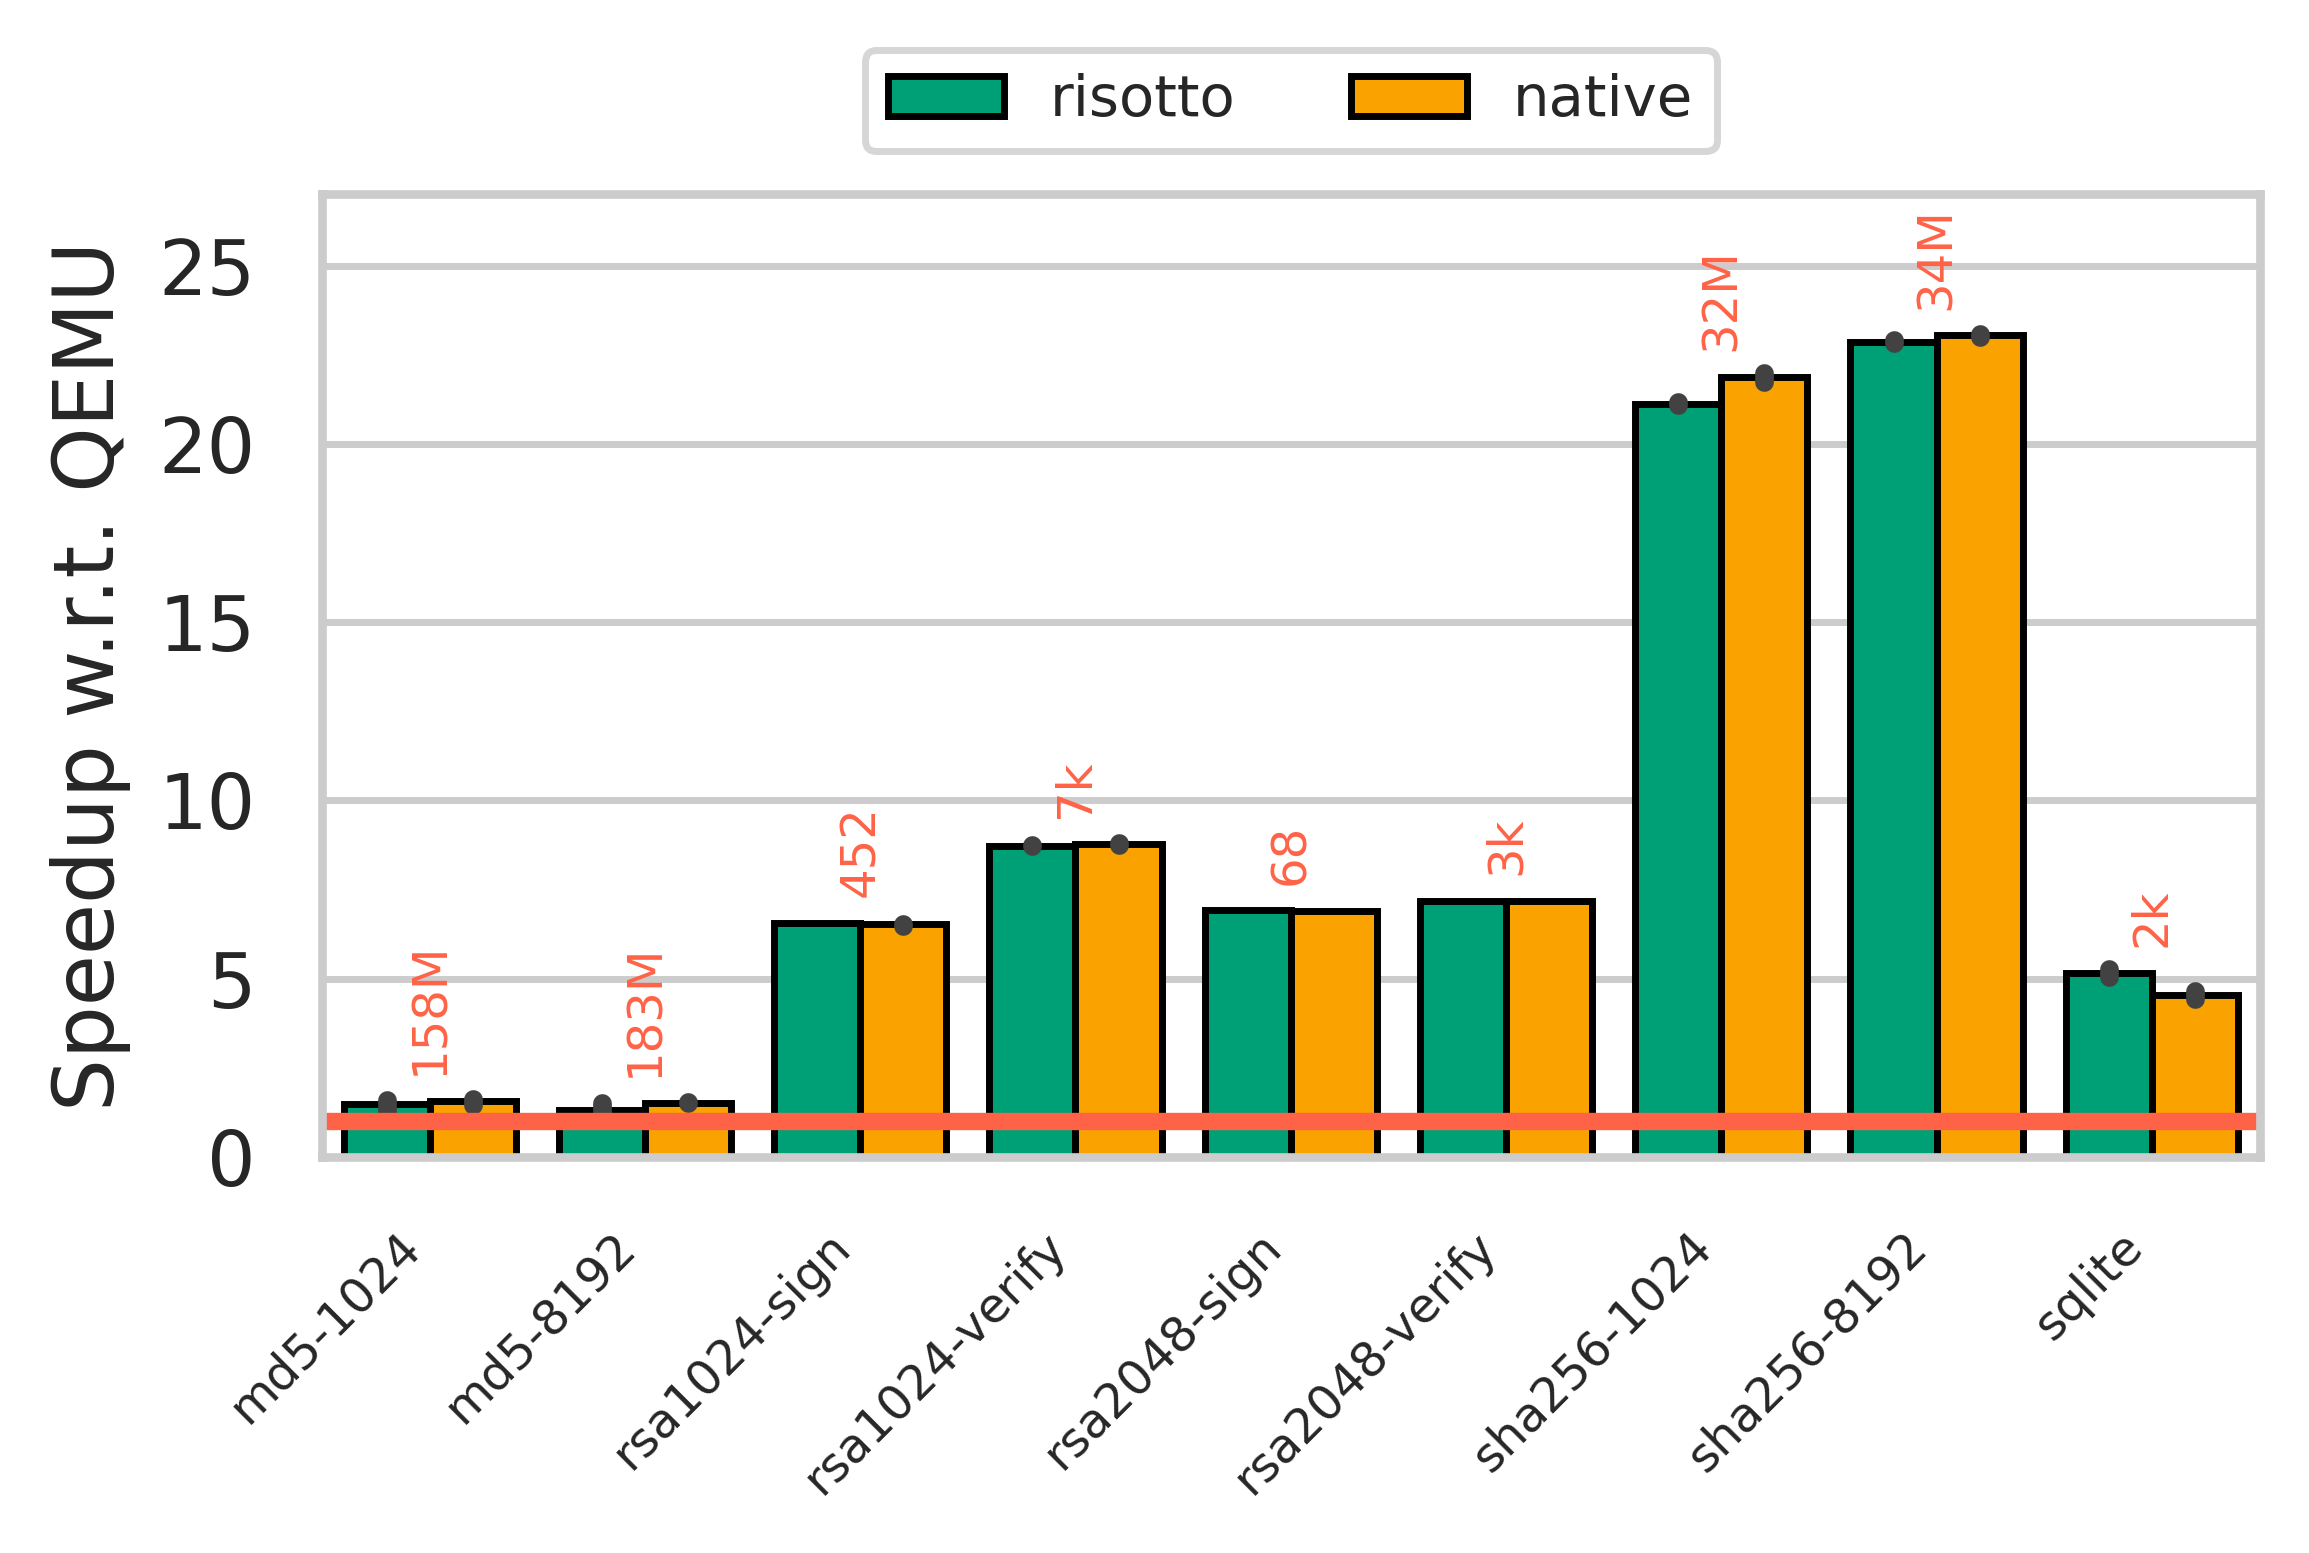

In [23]:
fig = plt.figure(figsize=(5,2.5), dpi=500)
sbs.set(style="whitegrid")
palette = {
    'orange': '#faa200',
    'sky blue': '#00b7ec',
    'bluish green': '#00a077',
    'yellow': '#f5e636',
    'blue': '#0077b8',
    'vermillion': '#f3640d',
    'reddish purple': '#e47ead'
}
ax = sbs.barplot(data=df_norm, x='bench', y='norm', hue='label',
                 hue_order=['risotto', 'native'], order=sorted_nicely(base_means))
plt.grid(visible=True, axis='y')
plt.xticks(ticks=range(0, len(set(df_norm['bench']))),
           labels=[ l[8:] for l in sorted_nicely(base_means) ],  # remove openssl. from the x ticks
           rotation=45, ha="right", fontsize='xx-small')
plt.xlabel("")
plt.ylabel("Speedup w.r.t. QEMU")
plt.ylim((0, 27))
plt.axhline(y=1, xmin=0, xmax=1, color='tomato', linewidth=2.5)
# Annotate the raw value of the baseline
for idx, value in enumerate(sorted_nicely(set(base_means))):
    if base_means[value] > 1000000:
        v = f"{base_means[value] / 1000000:.0f}M"
    elif base_means[value] > 1000:
        v = f"{base_means[value] / 1000:.0f}k"
    else:
        v = f"{base_means[value]:.0f}"
    tmp = max(mean_df.loc[mean_df['bench'] == value].values[0][1:]) / base_means[value]
    plt.text(idx, tmp+1, f"{v}", fontsize='xx-small', color='tomato', rotation=90, ha='center')
    #plt.text(idx, max(tmp+.3, 21), f"{v}", fontsize='xx-small', color='tomato', rotation=45, ha='center')
#plt.vlines(range(0, len(set(base_means))), ymin=0, ymax=20.8, linestyle='dashed', colors='grey', linewidth=.5, zorder=0)

# Set color + hatch
style = {
    'fill': [ True, True ],
    'color': [ palette['bluish green'], palette['orange'] ],
    'hatch': [ '', '', ''],
    'edgecolor': [ 'black', 'black', 'black' ]
}
for idx, bar in enumerate(ax.patches):
    bar_nr = int(idx / int(len(base_means)))
    bar.set(color=style['color'][bar_nr], fill=style['fill'][bar_nr],
            hatch=style['hatch'][bar_nr], edgecolor=style['edgecolor'][bar_nr])

plt.legend(loc='upper center', bbox_to_anchor=(.5, 1.15), borderaxespad=0, ncol=2, fontsize='x-small')

In [24]:
fig.savefig(fig13.pdf, dpi=500, bbox_inches='tight')

In [25]:
for i in sorted_nicely(base_means):
    print(f"{i:25}: {base_means[i]:>20.1f}")

openssl.md5-1024         :          158213392.0
openssl.md5-8192         :          183169360.0
openssl.rsa1024-sign     :                451.8
openssl.rsa1024-verify   :               7465.6
openssl.rsa2048-sign     :                 68.4
openssl.rsa2048-verify   :               2698.7
openssl.sha256-1024      :           32053142.0
openssl.sha256-8192      :           34171564.0
xxxxxxx.sqlite           :               1789.7


In [26]:
print(value)
max(mean_df.loc[mean_df['bench'] == value].values[0][1:]) / base_means[value]

xxxxxxx.sqlite


5.161426074014737

In [27]:
mean_df['risotto-speedup'] = mean_df['risotto'] / mean_df['qemu']
mean_df

,bench,native,risotto,qemu,risotto-speedup
0,openssl.md5-1024,2.491730e+08,2.353383e+08,1.582134e+08,1.487474
1,openssl.md5-8192,2.782968e+08,2.384687e+08,1.831694e+08,1.301903
2,openssl.rsa1024-sign,2.945029e+03,2.963330e+03,4.518208e+02,6.558640
3,openssl.rsa1024-verify,6.553898e+04,6.512559e+04,7.465632e+03,8.723386
4,openssl.rsa2048-sign,4.717624e+02,4.732399e+02,6.837911e+01,6.920826
5,openssl.rsa2048-verify,1.936062e+04,1.935696e+04,2.698664e+03,7.172793
6,openssl.sha256-1024,7.012102e+08,6.772491e+08,3.205314e+07,21.128948
7,openssl.sha256-8192,7.873872e+08,7.812162e+08,3.417156e+07,22.861587
8,xxxxxxx.sqlite,8.139139e+03,9.237333e+03,1.789686e+03,5.161426
